# Anomaly Detection Analysis

## Preproccess

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
        print(e)

### Import Lib

In [2]:
# Import the libraries
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json,os,glob
from IPython.core.pylabtools import figsize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
#import solve_cudnn
#solve_cudnn.solve_cudnn_error()

figsize(15, 7)

### Utils

In [3]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(df.iloc[:].index,Values[:bound, group],linewidth=3)
        plt.plot(df.iloc[:].index,Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], loc='right')
        plt.grid()
        plt.xticks(rotation=45)
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group,method):
    plt.matshow(df.iloc[:,group].corr(method=method),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('{}_original'.format(method), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [4]:
def gen_dataset(data,y_column_list,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, y_column_list ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    
    if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
    feb_index = data.loc['2021-02'].index.shape[0]
    
    #Y Columns
    y_column=[0,1,2,3,4,5,6,7]
    
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data_scaled = scaler.fit_transform(data)     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0,1))
        data_scaled = scaler.fit_transform(data)     

    #training-test split
    training_set = data_scaled[:feb_index,:]
    testing_set = data_scaled[feb_index:,:]
    print("Train set:{}".format(training_set.shape))
    print("Test set:{}".format(testing_set.shape))
    
    #generate dataset
    train_X,train_y = gen_dataset(training_set,y_column,X_win_size,y_win_size)
    test_X,test_y = gen_dataset(testing_set,y_column,X_win_size,y_win_size)

    #return  
    
    return train_X,train_y,test_X,test_y,scaler,data_scaled

### Read Data

In [5]:
root_path = r"E:\Server_mantain\Zabbix_Online_detection\Dataset"
FILENAME1 = "5v_180days.csv"
data_5v_path = os.path.join(root_path,"OPTIdata",FILENAME1)

### Split Usage and Quene

In [ ]:
import glob

with open(os.path.join(root_path,"OPTIdata","names.txt"),"r") as f:
    names = f.read().split("\n")
    
def get_index_num(df,col_names):
    
    num = []
    for col in col_names:
        num.append(df[df['name']==col].shape[0])
    num.sort()
    return num[0]
    
for csv in glob.glob(os.path.join(root_path,"OPTIdata","*_180days.csv")):
    
    dict_5v = {}
    dict_5v_quene = {}
    temp_shape = []
    data_name = csv.split("\\")[-1].split("_")[0]
    data_5v = read_data(csv,dt_name='datetime')
    
    print(names[4:])
    ind_usage = get_index_num(data_5v,names[4:])
    ind_quene = get_index_num(data_5v,names[:4])
    
    ind = data_5v[data_5v['name']==names[4]][:ind_usage].index
    ind2 = data_5v[data_5v['name']==names[0]][:ind_quene].index
    
    
    
    
    for name in names[4:]:
        #usage&freespace
        dict_5v[name+"_"+data_name] = data_5v[data_5v['name']==name].values[:ind_usage,-1]
        print(data_5v[data_5v['name']==name].values[:,-1].shape[0])
    for name in names[:4]:
        #quene
        dict_5v_quene[name+"_"+data_name] = data_5v[data_5v['name']==name].values[:ind_quene,-1]
        print(data_5v[data_5v['name']==name].values[:,-1].shape[0])
    
    concat1 = pd.DataFrame(dict_5v,index=ind)
    concat2 = pd.DataFrame(dict_5v_quene,index=ind2)
    
    concat1.to_csv(os.path.join(root_path,"OPTIdata","pre_process","{}_180day_usage.csv".format(data_name)))
    concat2.to_csv(os.path.join(root_path,"OPTIdata","pre_process","{}_180day_quene.csv".format(data_name)))

### Concat Usage & Quene Data and Add Anomaly Label  
#### 2021/9/11 09:34  最後quene

In [ ]:
from IPython.core.pylabtools import figsize
 
figsize(30, 17) 
for csv in glob.glob(os.path.join(root_path,"OPTIdata","*_180days.csv")):
    
    server_name = csv.split("\\")[-1].split("_")[0]
    print(server_name)
    data = read_data(csv,o_dtname="datetime",c_dtname = 'Datetime')
    
    #get Specified name columns
    QoC_df = data[data["name"]=="Disk (0 C:) - Current Disk Queue Length"]
    QoD_df = data[data["name"]=="Disk (1 D:) - Current Disk Queue Length"]
    MEMUSG_df = data[data["name"]=="Memory used  (%)"]
    CPUUSG_df = data[data["name"]=="CPU utilization (%)"]
    
    #get last time
    #merge_time = str(QoC_df.index[-1])
    
    #select concat column  "2021/9/11 09:34"
    select_col_list = [MEMUSG_df.loc[:,["value"]],
                   CPUUSG_df.loc[:,["value"]],
                   QoC_df.loc[:,["value"]],
                   QoD_df.loc[:,["value"]]]

    new_df = pd.concat(select_col_list,axis=1)
    new_df["Memory used  (%)"] = new_df.iloc[:,0]
    new_df["CPU utilization (%)"] = new_df.iloc[:,1]
    new_df["Disk (0 C:) - Current Disk Queue Length"] = new_df.iloc[:,2]
    new_df["Disk (1 D:) - Current Disk Queue Length"] = new_df.iloc[:,3]
    new_df = new_df.drop(columns="value")
    new_df.to_csv(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_beforefill.csv".format(server_name)))
    new_df.fillna(method='ffill', inplace=True)
    new_df.fillna(method='bfill', inplace=True)
    
    new_df["C_anomaly_label"] = new_df["Disk (0 C:) - Current Disk Queue Length"].apply(lambda x: 1 if x >= 3 else 0)
    new_df["D_anomaly_label"] = new_df["Disk (1 D:) - Current Disk Queue Length"].apply(lambda x: 1 if x >= 3 else 0)
    new_df["anomaly_value"] = new_df["C_anomaly_label"]+ new_df["D_anomaly_label"]
    new_df["anomaly_label"] = new_df["anomaly_value"].apply(lambda x: 1 if x >= 1 else 0)
    new_df = new_df.drop(columns=["C_anomaly_label","D_anomaly_label","anomaly_value"])
    new_df.to_csv(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly.csv".format(server_name)))
    print(new_df.shape)
    plt.plot(new_df.index.values,new_df.iloc[:,0],label="Memory",color="blue",zorder=10,marker='.',linewidth=2)
    plt.plot(new_df.index.values,new_df.iloc[:,1],label="CPU",color="green",zorder=20,marker='.',linewidth=2)
    plt.scatter(new_df[new_df["anomaly_label"]==1].index.values,new_df[new_df["anomaly_label"]==1]["CPU utilization (%)"].values,
                s=400,
                color="red",
                label="CPU Failure",
                zorder=30,
                edgecolors="blue",
                linewidth=3,
                hatch=r'\\\\')
    plt.scatter(new_df[new_df["anomaly_label"]==1].index.values,new_df[new_df["anomaly_label"]==1]["Memory used  (%)"].values,
                s=400,
                color="red",
                label="MEM Failure",
                zorder=30,
                edgecolors="green",
                linewidth=3,
                hatch='////')
    plt.title("{}_server_180dayswithanomaly".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Usage",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(range(0,120,20),fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly.jpg".format(server_name)))
    plt.show()
    
    
    #Resample data by HOUR mean and sum
    resample_data = pd.concat([new_df.iloc[:,[0,1]].resample("h").mean(),new_df.iloc[:,[2,3,4]].resample("h").sum()],axis=1)
    resample_data["Label"] = resample_data["anomaly_label"].apply(lambda x: 1 if x >= 1 else 0)
    
    
    
    plt.plot(resample_data.index.values,resample_data.iloc[:,0],label="Memory",color="blue",zorder=10,marker='.',linewidth=2)
    plt.plot(resample_data.index.values,resample_data.iloc[:,1],label="CPU",color="green",zorder=20,marker='.',linewidth=2)
    plt.scatter(resample_data[resample_data["anomaly_label"]>1].index.values,resample_data[resample_data["anomaly_label"]>1]["CPU utilization (%)"].values,
                s=400,
                color="red",
                label="CPU Failure",
                zorder=30,
                edgecolors="blue",
                linewidth=3,
                hatch=r'\\\\')
    plt.scatter(resample_data[resample_data["anomaly_label"]>1].index.values,resample_data[resample_data["anomaly_label"]>1]["Memory used  (%)"].values,
                s=400,
                color="red",
                label="MEM Failure",
                zorder=30,
                edgecolors="green",
                linewidth=3,
                hatch='////')
    plt.title("{}_server_180dayswithanomaly_resampleHOUR".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Usage",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(range(0,120,20),fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR.jpg".format(server_name)))
    plt.show()
    
    plt.bar(resample_data["anomaly_label"].index.values,resample_data["anomaly_label"].values,label="Number of Accumulate Quene",color="blue")
    plt.title("{}_server_180dayswithanomaly_resampleHOUR_bar".format(server_name),fontsize=30)
    plt.xlabel("Datetime",fontsize=20)
    plt.ylabel("Accumulate Quene",fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=10)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR_bar.jpg".format(server_name)))
    plt.show()
    
    resample_data = resample_data.drop(columns="anomaly_label")
    resample_data.to_csv(os.path.join(root_path,
                                      "OPTIdata",
                                      "pre_process_withlabel",
                                      "{}_server_180dayswithanomaly_resampleHOUR_quene_sum.csv".format(server_name)))
    
    
    
    #Resample data by HOUR mean
    resample_data_mean = pd.concat([new_df.iloc[:,[0,1]].resample("h").mean(),new_df.iloc[:,[2,3,4]].resample("h").mean()],axis=1)
    #resample_data_mean["Label"] = resample_data_mean["anomaly_label"].apply(lambda x: 1 if x >= 1 else 0)
    
    
    
    
    
    #resample_data_mean = resample_data_mean.drop(columns="anomaly_label")
    resample_data_mean.to_csv(os.path.join(root_path,
                                      "OPTIdata",
                                      "pre_process_withlabel",
                                      "{}_server_180dayswithanomaly_resampleHOUR_quene_mean.csv".format(server_name)))
    
    
    

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         28.566922            39.851956   
2021-06-20 10:00:00         28.828743            37.081960   
2021-06-20 11:00:00         27.201200            37.182560   
2021-06-20 12:00:00         28.462700            31.697695   
2021-06-20 13:00:00         27.996105            43.175465   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

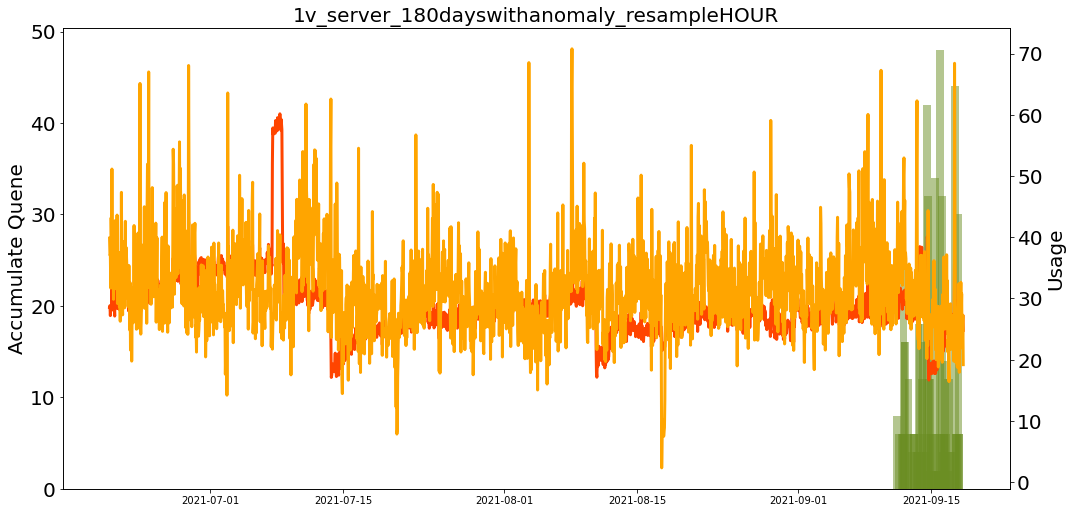

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         14.113606             1.207067   
2021-06-20 10:00:00         14.095523             1.461820   
2021-06-20 11:00:00         14.128880             1.280370   
2021-06-20 12:00:00         14.089222             1.241520   
2021-06-20 13:00:00         14.128913             1.258165   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

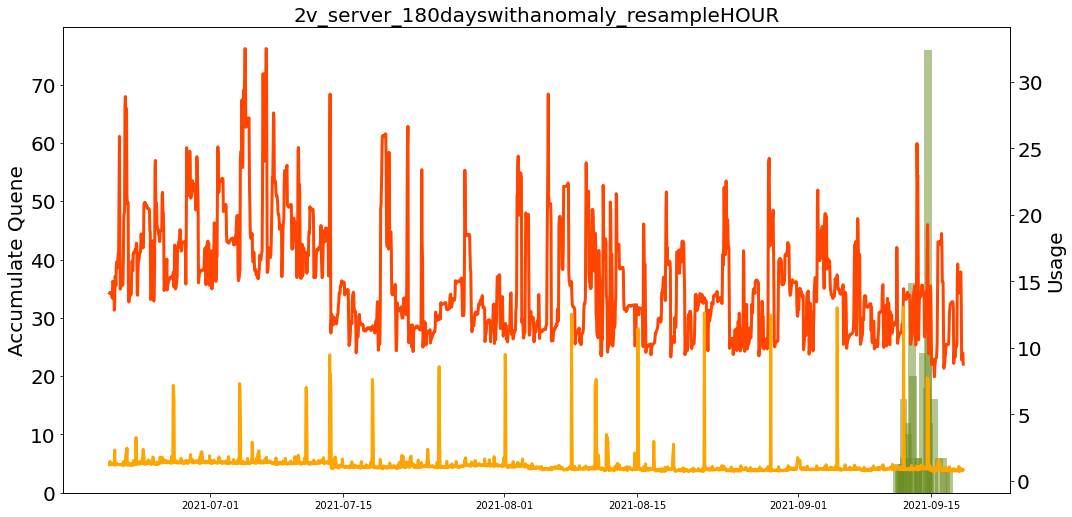

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         19.636733             8.287033   
2021-06-20 10:00:00         20.635300            10.620855   
2021-06-20 11:00:00         19.013268             8.150290   
2021-06-20 12:00:00         20.051527             6.334245   
2021-06-20 13:00:00         19.982570             8.900310   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

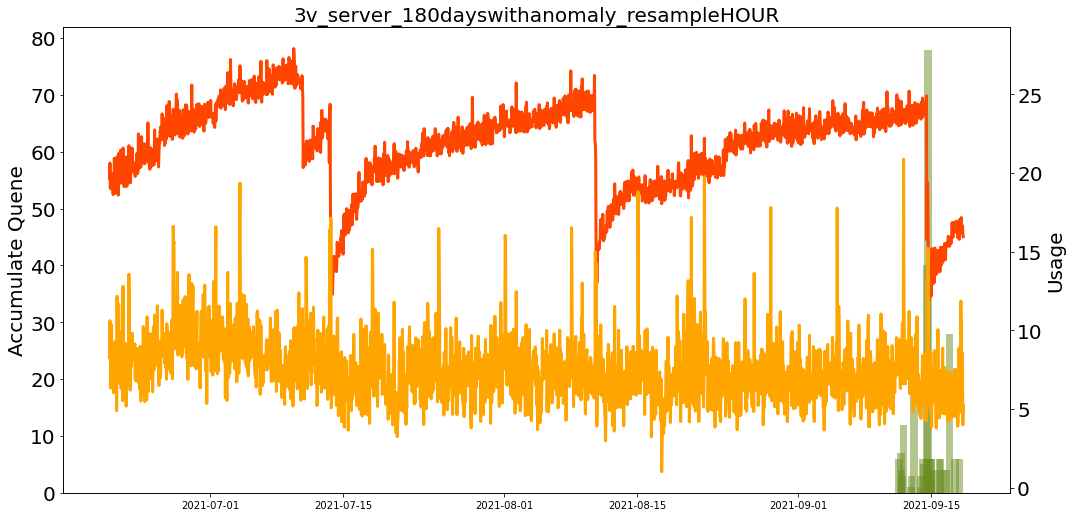

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         12.935383             1.118944   
2021-06-20 10:00:00         12.926137             1.078355   
2021-06-20 11:00:00         12.936700             1.078200   
2021-06-20 12:00:00         12.991245             1.120410   
2021-06-20 13:00:00         13.001953             1.094930   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

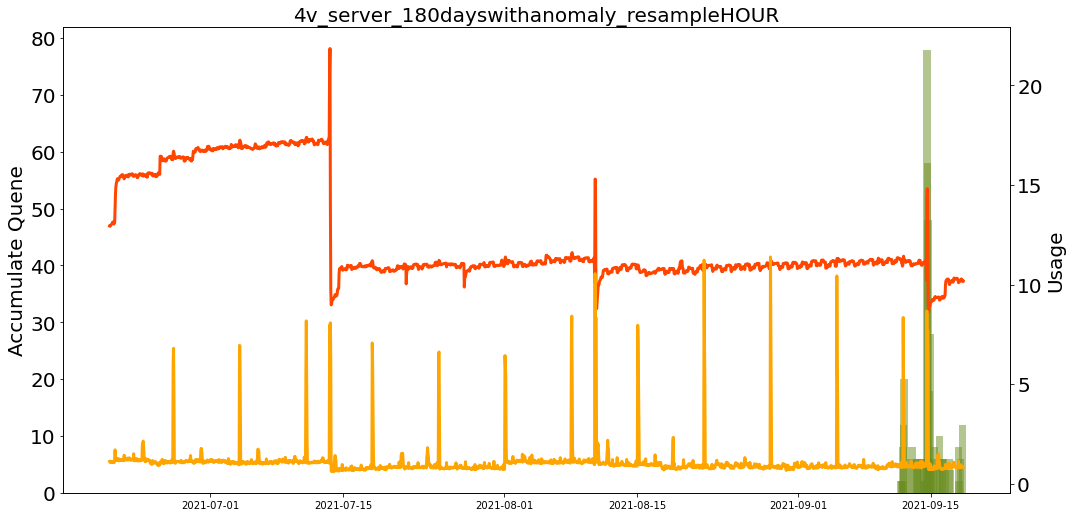

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         15.324467             4.633911   
2021-06-20 10:00:00         14.341952             8.398715   
2021-06-20 11:00:00         14.190687             6.687040   
2021-06-20 12:00:00         15.669625             9.170250   
2021-06-20 13:00:00         14.167898             6.942100   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

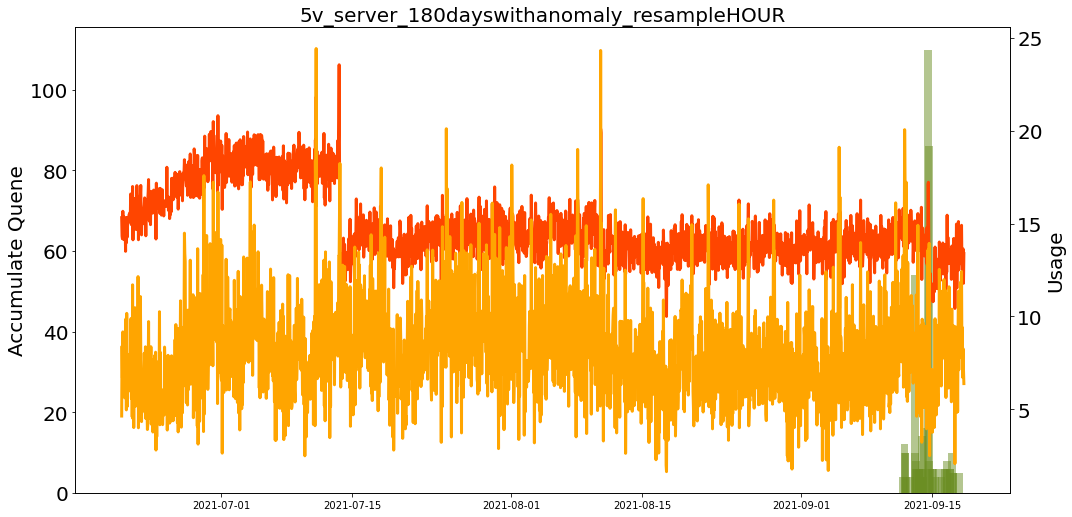

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 10:00:00         68.997344            80.346878   
2021-06-20 11:00:00         69.694937            77.582825   
2021-06-20 12:00:00         62.959915            77.360200   
2021-06-20 13:00:00         64.110505            78.613925   
2021-06-20 14:00:00         63.443767            76.853580   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06-20 12:00:00                                      0.0   
2021-06

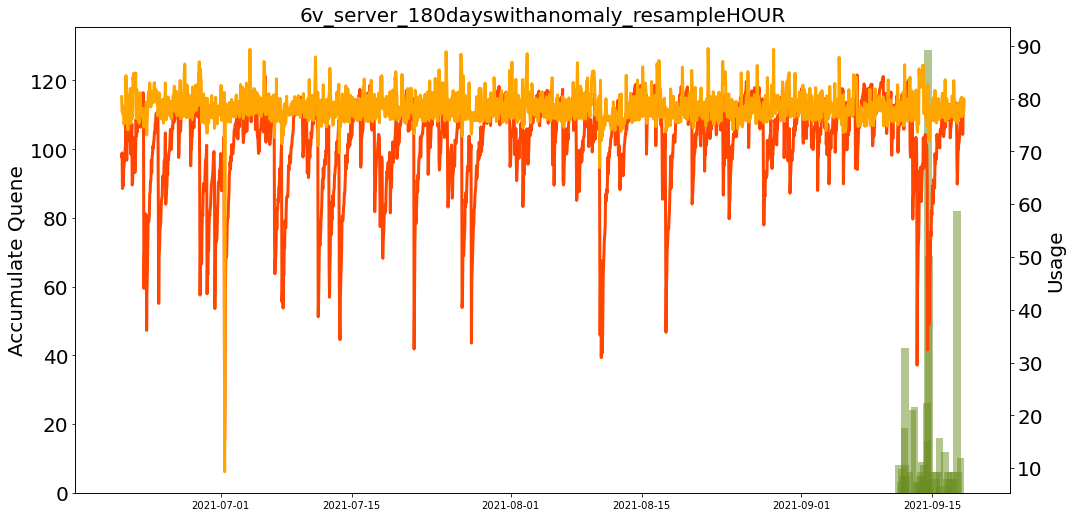

In [86]:
#Usage vs. Quene mean

for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):
    figsize(15,7)
    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    df = df.loc[:,:]
    server_name = path.split("\\")[-1].split("_")[0]
    print(df.head())
    fig, ax1 = plt.subplots()
    
    
    
    ax2 = ax1.twinx()
    
    
    
    ax1.set_ylabel("Accumulate Quene",fontsize=20)
    ax1.bar(df["Disk (0 C:) - Current Disk Queue Length"].index.values,
            df["Disk (0 C:) - Current Disk Queue Length"].values,
            label="Number of Accumulate Quene",
            zorder=1,
            alpha = 0.5,
            color='olivedrab'
           )
    ax1.tick_params(axis='y',labelsize=20)
    
    ax2.set_ylabel("Usage",fontsize=20)
    ax2.plot(df["Memory used  (%)"].index.values,
             df["Memory used  (%)"].values,
             label="Memory used  (%)",
             zorder=10,
            linewidth=3,
            color='orangered')
    ax2.plot(df["CPU utilization (%)"].index.values,
             df["CPU utilization (%)"].values,
             label="CPU utilization (%)",
             zorder=10,
            linewidth=3,
            color='orange')
    #ax1.legend(fontsize='xx-large')
    
    ax2.tick_params(axis='y',labelsize=20)
    ax2.tick_params(axis='x',labelsize=20)
    
    fig.tight_layout()
    plt.title("{}_server_180dayswithanomaly_resampleHOUR".format(server_name),fontsize=20)
    #plt.xtick(fontsize=20)
    plt.xlabel("Datetime",fontsize=10)
    
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR_line_and_bar.jpg".format(server_name)),bbox_inches="tight")
    plt.show()
    

### Concat 1v~6v Resample Data 

In [ ]:
#Usage vs. Quene mean
df_list = []
for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):

    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    df_list.append(df)
    server_name = path.split("\\")[-1].split("_")[0]
    print(server_name)
    
df_concat = pd.concat(df_list,axis=1)  
df_concat.fillna(method='ffill', inplace=True)
df_concat.fillna(method='bfill', inplace=True)
df_concat.to_csv(os.path.join(root_path,
                                      "OPTIdata",
                                      "pre_process_withlabel",
                                      "1vto6v_server_180dayswithanomaly_resampleHOUR_quene_sum_concat.csv"))


In [ ]:
df = read_data(os.path.join(root_path,
                      "OPTIdata",
                      "pre_process_withlabel",
                      "1vto6v_server_180dayswithanomaly_resampleHOUR_quene_sum_concat.csv"),
                      o_dtname="dt",
                        c_dtname='Datetime')
df

## Data Analysis

### Plot Distribution

In [ ]:
import seaborn as sns

sns.displot(resample_data.loc["2021-09-15":],x="Memory used  (%)")
sns.displot(resample_data.loc[:"2021-09-15"],x="Memory used  (%)")
sns.displot(resample_data.loc["2021-09-15":],x="CPU utilization (%)")
sns.displot(resample_data.loc[:"2021-09-15"],x="CPU utilization (%)")

In [ ]:

    
dict_5v = {}
dict_5v_quene = {}
for name in names[4:]:
    dict_5v[name] = data_5v[data_5v['name']==name].values[:,-1]
for name in names[:4]:
    dict_5v_quene[name] = data_5v[data_5v['name']==name].values[:,-1]
    
concat1 = pd.DataFrame(dict_5v,index=ind)
concat2 = pd.DataFrame(dict_5v_quene,index=ind2)
#concat1.to_csv(os.path.join(root_path,"OPTIdata","5v_180day.csv"))
#concat2.to_csv(os.path.join(root_path,"OPTIdata","5v_180day_concat_quene.csv"))

### T-SNE Analysis

In [ ]:
df = read_data("./Dataset/OPTIdata/pre_process_withlabel/5v_server_180dayswithanomaly_resampleHOUR.csv",
          o_dtname="Datetime",
          c_dtname='dt')


#### single server tsne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
#Prepare the data

for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR.csv"):

    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    
    server_name = path.split("\\")[-1].split("_")[0]
    X, y = df.iloc[:,:4].values,df.iloc[:,-1].values

    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(X[:,[0,1]]) 


    
    
    plt.figure(figsize=(8, 8))
    for i in range(1,7,1):
        
        #t-SNE
        print("Training...")
        X_tsne = manifold.TSNE(n_components=2, init='random', 
                               random_state=5,
                               perplexity=i*10.0,
                               verbose=0).fit_transform(data_scaled)

        #Data Visualization
        x_min, x_max = X_tsne.min(0), X_tsne.max(0)
        X_norm = (X_tsne-x_min) / (x_max - x_min)  #Normalize
        print("Done")
        plt.subplot(3,2,i)
        for i in range(X_norm.shape[0]):
                if y[i] == 0:
                    plt.scatter(X_norm[i, 0], X_norm[i, 1], color='r',zorder=10)
                    #plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
                             #fontdict={'weight': 'bold', 'size': 9})
                else:
                    plt.scatter(X_norm[i, 0], X_norm[i, 1], color='b',zorder=30)
        
        plt.xticks([])
        plt.yticks([])
    plt.title(server_name)
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_tsne.jpg".format(server_name)))
    plt.show()
    
       

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    if y[i] == 0:
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color='r')
        #plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
                 #fontdict={'weight': 'bold', 'size': 9})
    else:
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color='b')
plt.xticks([])
plt.yticks([])
plt.show()

#### 1v~6v server tsne

In [8]:
with open("Dataset/OPTIdata/pre_process_withlabel/columns_names.txt") as f:
    names = f.read().split("\n")
names

['dt',
 '1v_Memory used  (%)',
 '1v_CPU utilization (%)',
 '1v_Disk (0 C:) - Current Disk Queue Length',
 '1v_Disk (1 D:) - Current Disk Queue Length',
 '1v_Label',
 '2v_Memory used  (%)',
 '2v_CPU utilization (%)',
 '2v_Disk (0 C:) - Current Disk Queue Length',
 '2v_Disk (1 D:) - Current Disk Queue Length',
 '2v_Label',
 '3v_Memory used  (%)',
 '3v_CPU utilization (%)',
 '3v_Disk (0 C:) - Current Disk Queue Length',
 '3v_Disk (1 D:) - Current Disk Queue Length',
 '3v_Label',
 '4v_Memory used  (%)',
 '4v_CPU utilization (%)',
 '4v_Disk (0 C:) - Current Disk Queue Length',
 '4v_Disk (1 D:) - Current Disk Queue Length',
 '4v_Label',
 '5v_Memory used  (%)',
 '5v_CPU utilization (%)',
 '5v_Disk (0 C:) - Current Disk Queue Length',
 '5v_Disk (1 D:) - Current Disk Queue Length',
 '5v_Label',
 '6v_Memory used  (%)',
 '6v_CPU utilization (%)',
 '6v_Disk (0 C:) - Current Disk Queue Length',
 '6v_Disk (1 D:) - Current Disk Queue Length',
 '6v_Label']

In [9]:
path = r"E:\Server_mantain\Zabbix_Online_detection\Dataset\OPTIdata\pre_process_withlabel\1vto6v_server_180dayswithanomaly_resampleHOUR_quene_sum_concat.csv"
df = read_data(path,
          o_dtname="dt",
          c_dtname='Datetime',
              names=names,
              skiprows=1)



1v_Memory used  (%)                           0
1v_CPU utilization (%)                        0
1v_Disk (0 C:) - Current Disk Queue Length    0
1v_Disk (1 D:) - Current Disk Queue Length    0
1v_Label                                      0
2v_Memory used  (%)                           0
2v_CPU utilization (%)                        0
2v_Disk (0 C:) - Current Disk Queue Length    0
2v_Disk (1 D:) - Current Disk Queue Length    0
2v_Label                                      0
3v_Memory used  (%)                           0
3v_CPU utilization (%)                        0
3v_Disk (0 C:) - Current Disk Queue Length    0
3v_Disk (1 D:) - Current Disk Queue Length    0
3v_Label                                      0
4v_Memory used  (%)                           0
4v_CPU utilization (%)                        0
4v_Disk (0 C:) - Current Disk Queue Length    0
4v_Disk (1 D:) - Current Disk Queue Length    0
4v_Label                                      0
5v_Memory used  (%)                     

In [5]:
for i,col in enumerate(df.columns):
    print(i,col)

NameError: name 'df' is not defined

In [ ]:
path = r"E:\Server_mantain\Zabbix_Online_detection\Dataset\OPTIdata\pre_process_withlabel\1vto6v_server_180dayswithanomaly_resampleHOUR_quene_sum_concat.csv"
df = read_data(path,
          o_dtname="dt",
          c_dtname='Datetime',
              names=names,
              skiprows=1)




X, y = df.iloc[:,[]]

from sklearn.preprocessing import MinMaxScaler,RobustScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(X[:,[0,1]]) 




plt.figure(figsize=(8, 8))
for i in range(1,7,1):

    #t-SNE
    print("Training...")
    X_tsne = manifold.TSNE(n_components=2, init='random', 
                           random_state=5,
                           perplexity=i*10.0,
                           verbose=0).fit_transform(data_scaled)

    #Data Visualization
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max - x_min)  #Normalize
    print("Done")
    plt.subplot(3,2,i)
    for i in range(X_norm.shape[0]):
            if y[i] == 0:
                plt.scatter(X_norm[i, 0], X_norm[i, 1], color='r',zorder=10)
                #plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
                         #fontdict={'weight': 'bold', 'size': 9})
            else:
                plt.scatter(X_norm[i, 0], X_norm[i, 1], color='b',zorder=30)

    plt.xticks([])
    plt.yticks([])

### Usage vs. Quene Analysis 

In [ ]:
import numpy as np

#Usage vs. Quene
for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly.csv"):
    
    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    print(df.shape)

    server_name = path.split("\\")[-1].split("_")[0]
    
    #plt.fill_between([0,100],20,[3,3],linewidth=20,facecolor='red', alpha=0.10,zorder=10)
    plt.scatter(df["CPU utilization (%)"].values,df["Disk (0 C:) - Current Disk Queue Length"].values,s=500,label="{}:x=CPU Usage\ny=C: Quene".format(server_name),zorder=20)
    
    
    for i in range(df["CPU utilization (%)"].values.shape[0],df["CPU utilization (%)"].values.shape[0],1):
        if df["Disk (0 C:) - Current Disk Queue Length"].values[i]>=3:
            plt.scatter(df["CPU utilization (%)"].values[i],df["Disk (0 C:) - Current Disk Queue Length"].values[i],s=500,color='red',zorder=30)
    
        
plt.plot([0,100],[3,3],linewidth=5,color='red',zorder=10)            
plt.xlabel("CPU utilization (%)",fontsize=20)
plt.ylabel("Disk (0 C:) - Current Disk Queue Length",fontsize=20)
plt.legend(fontsize='xx-large')
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.title("Quene vs. Usage origin data",fontsize=20)
plt.grid()
plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","Quene_vs_Usage_0911_0934.jpg"))
plt.show()

#Usage vs. Quene mean
for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):

    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    print(df.shape)
    server_name = path.split("\\")[-1].split("_")[0]
    
    plt.scatter(df["CPU utilization (%)"].values,df["Disk (0 C:) - Current Disk Queue Length"].values,s=500,label="{}:x=CPU Usage\ny=C: Quene".format(server_name))
    for i in range(df["CPU utilization (%)"].values.shape[0],df["CPU utilization (%)"].values.shape[0],1):
        if df["Disk (0 C:) - Current Disk Queue Length"].values[i]>=3:
            plt.scatter(df["CPU utilization (%)"].values[i],df["Disk (0 C:) - Current Disk Queue Length"].values[i],s=500,color='red')
        
            
plt.plot([0,100],[3,3],linewidth=5,color='red',zorder=10)    
plt.xlabel("CPU utilization (%)",fontsize=20)
plt.ylabel("Disk (0 C:) - Current Disk Queue Length",fontsize=20)
plt.legend(fontsize='xx-large')
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.title("Quene vs. Usage origin data resample by hour",fontsize=20)
plt.grid()
plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","Quene_vs_Usage_resample_0911_0934.jpg"))
plt.show()

#MEMUsage vs. DQuene sum
for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):

    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    print(df.shape)
    server_name = path.split("\\")[-1].split("_")[0]
    
    plt.scatter(df["Memory used  (%)"].values,df["Disk (1 D:) - Current Disk Queue Length"].values,s=500,label="{}:x=Memory Usage\ny=D: Quene".format(server_name))
    for i in range(df["Memory used  (%)"].values.shape[0],df["Memory used  (%)"].values.shape[0],1):
        if df["Disk (1 D:) - Current Disk Queue Length"].values[i]>=3:
            plt.scatter(df["Memory used  (%)"].values[i],df["Disk (1 D:) - Current Disk Queue Length"].values[i],s=500,color='red')
        
            
plt.plot([0,100],[3,3],linewidth=5,color='red',zorder=10)    
plt.xlabel("Memory used  (%)",fontsize=20)
plt.ylabel("Disk (1 D:) - Current Disk Queue Length",fontsize=20)
plt.legend(fontsize='xx-large')
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.title("Quene vs. Usage origin data resample by hour",fontsize=20)
plt.grid()
plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","DQuene_vs_MEMUsage_resample_quene_sum.jpg"))
plt.show()

#CPUUsage vs. DQuene sum
for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):

    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    
    server_name = path.split("\\")[-1].split("_")[0]
    
    plt.scatter(df["CPU utilization (%)"].values,df["Disk (1 D:) - Current Disk Queue Length"].values,s=500,label="{}:x=Memory Usage\ny=D: Quene".format(server_name))
    for i in range(df["CPU utilization (%)"].values.shape[0],df["CPU utilization (%)"].values.shape[0],1):
        if df["Disk (1 D:) - Current Disk Queue Length"].values[i]>=3:
            plt.scatter(df["CPU utilization (%)"].values[i],df["Disk (1 D:) - Current Disk Queue Length"].values[i],s=500,color='red')
        
            
plt.plot([0,100],[3,3],linewidth=5,color='red',zorder=10)    
plt.xlabel("CPU utilization (%)",fontsize=20)
plt.ylabel("Disk (1 D:) - Current Disk Queue Length",fontsize=20)
plt.legend(fontsize='xx-large')
plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)
plt.title("Quene vs. Usage origin data resample by hour",fontsize=20)
plt.grid()
plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","DQuene_vs_CPUUsage_resample_quene_sum.jpg"))
plt.show()

### correlation Analysis
#### 5v correlation analysis

In [ ]:
import researchpy as rp

corr_type,corr_matrix,corr_ps = rp.corr_case(df)
pearson_res = rp.corr_pair(df)
spear_res = rp.corr_pair(df,method="spearman")
pearson_res.to_csv("5v_pearson_correlation.csv")
spear_res.to_csv("5v_spear_correlation.csv")

#### 1v~6v correlation analysis

Memory used  (%)                             0
CPU utilization (%)                          0
Disk (0 C:) - Current Disk Queue Length      0
Disk (1 D:) - Current Disk Queue Length      0
Label                                        0
Memory used  (%)2                            0
CPU utilization (%)3                         0
Disk (0 C:) - Current Disk Queue Length4     0
Disk (1 D:) - Current Disk Queue Length5     0
Label6                                       0
Memory used  (%)7                            0
CPU utilization (%)8                         0
Disk (0 C:) - Current Disk Queue Length9     0
Disk (1 D:) - Current Disk Queue Length10    0
Label11                                      0
Memory used  (%)12                           0
CPU utilization (%)13                        0
Disk (0 C:) - Current Disk Queue Length14    0
Disk (1 D:) - Current Disk Queue Length15    0
Label16                                      0
Memory used  (%)17                           0
CPU utilizati

C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\scipy\stats\stats.py:

save as Memory used  (%) & Memory used  (%)7_corr_plot.jpg


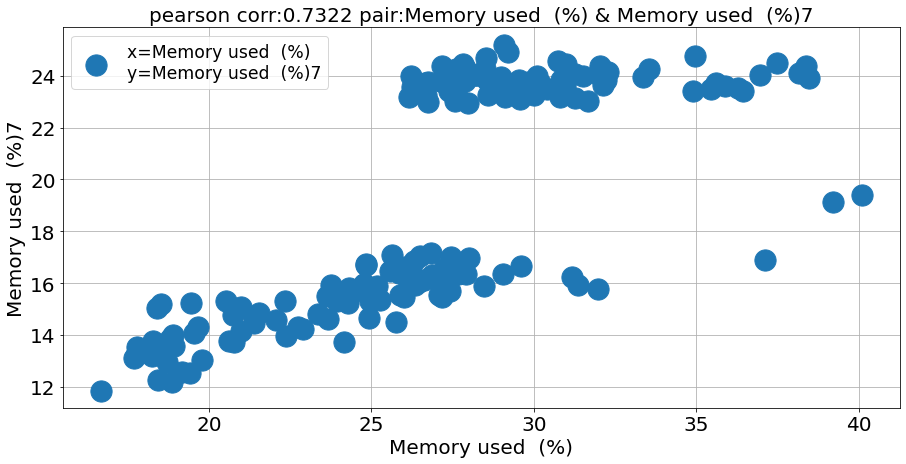

save as Memory used  (%) & Memory used  (%)12_corr_plot.jpg


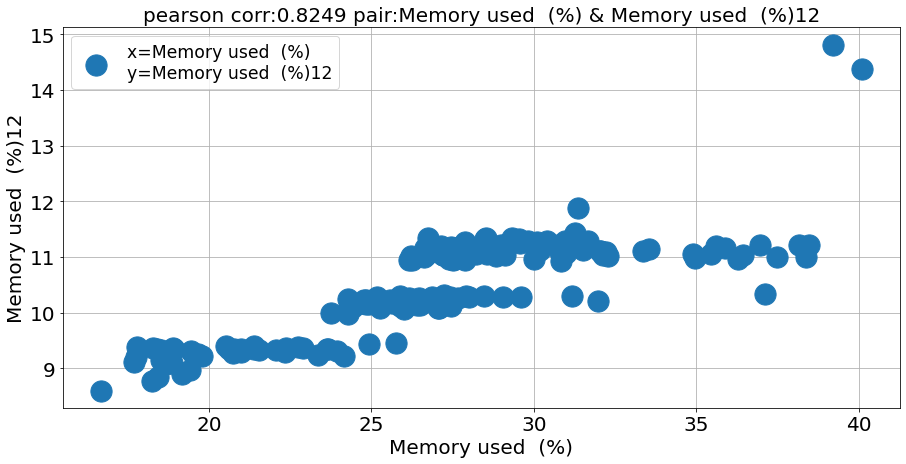

save as Disk (0 C:) - Current Disk Queue Length & Label_corr_plot.jpg


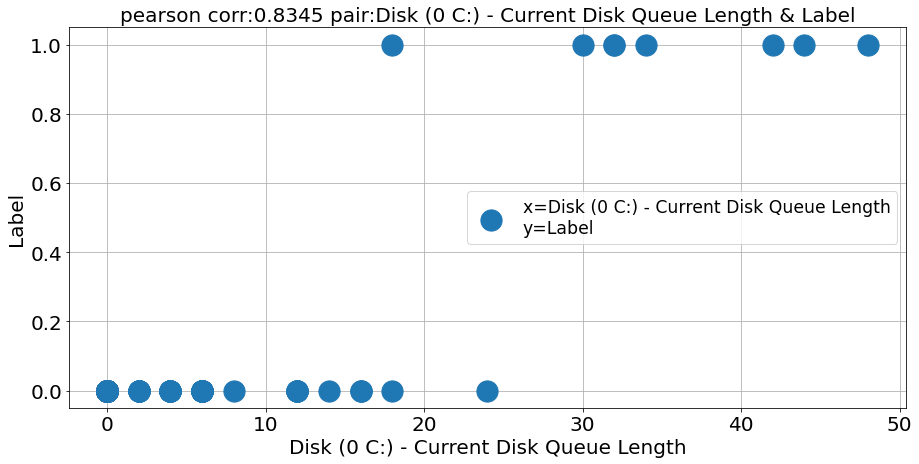

save as CPU utilization (%)3 & CPU utilization (%)13_corr_plot.jpg


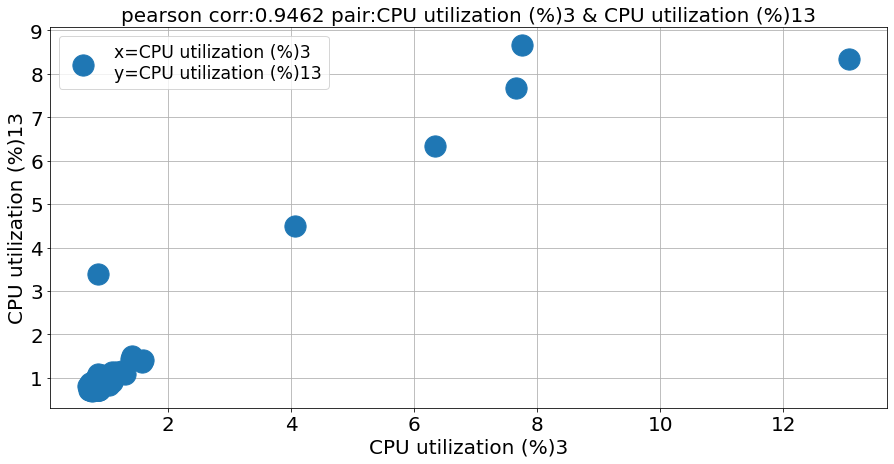

save as Disk (0 C:) - Current Disk Queue Length4 & Label6_corr_plot.jpg


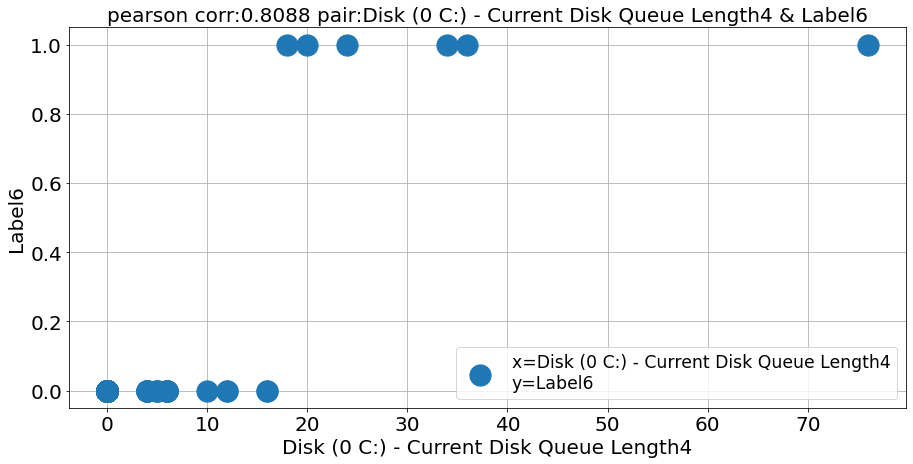

save as Memory used  (%)7 & Memory used  (%)12_corr_plot.jpg


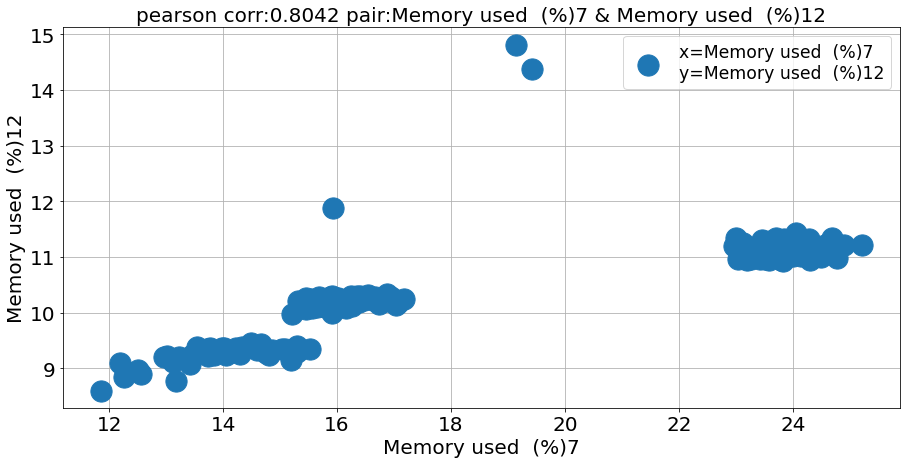

save as Disk (0 C:) - Current Disk Queue Length9 & Label11_corr_plot.jpg


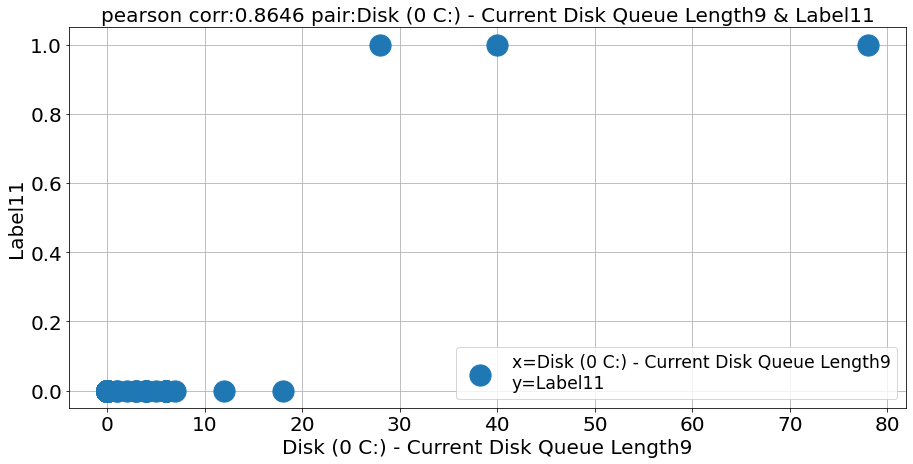

save as Disk (0 C:) - Current Disk Queue Length9 & Disk (0 C:) - Current Disk Queue Length19_corr_plot.jpg


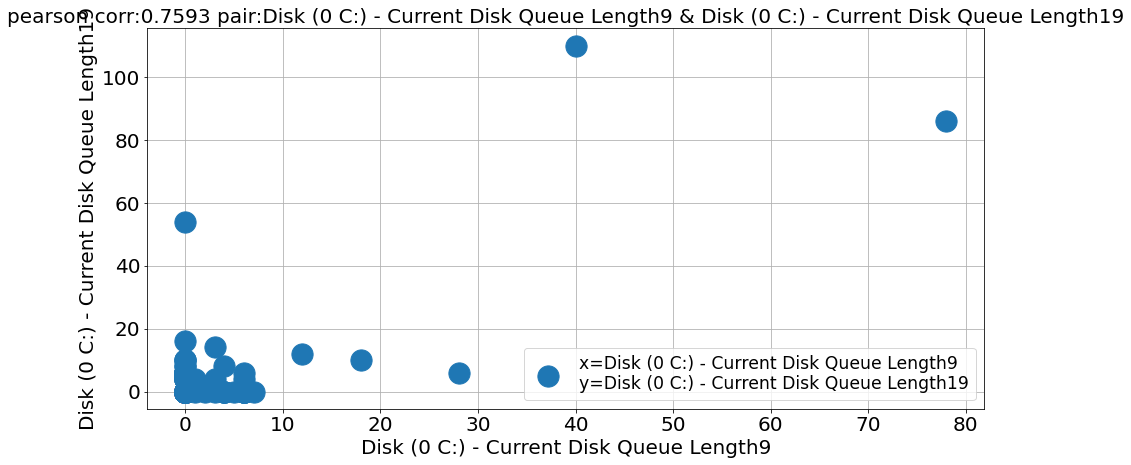

save as Label11 & Disk (0 C:) - Current Disk Queue Length19_corr_plot.jpg


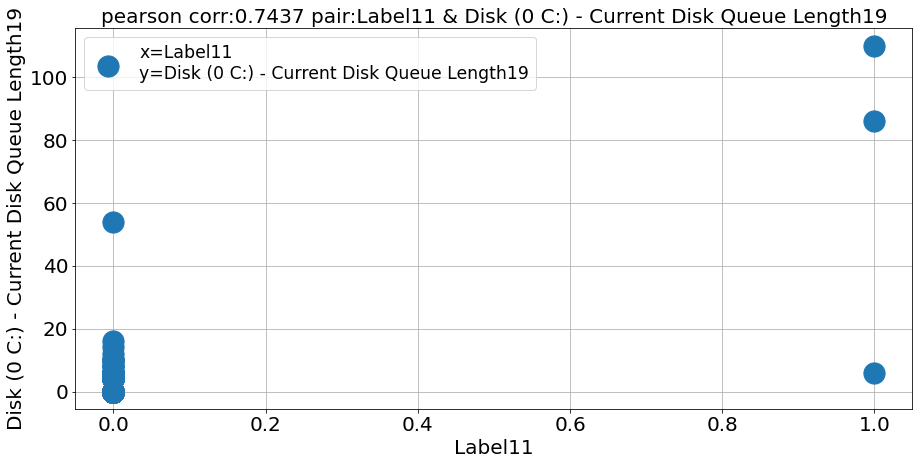

save as Memory used  (%)12 & Memory used  (%)17_corr_plot.jpg


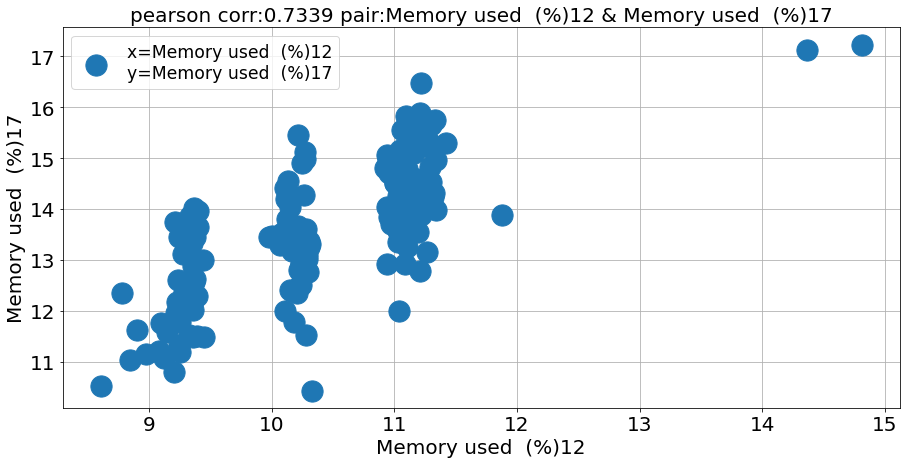

save as CPU utilization (%)13 & Disk (0 C:) - Current Disk Queue Length14_corr_plot.jpg


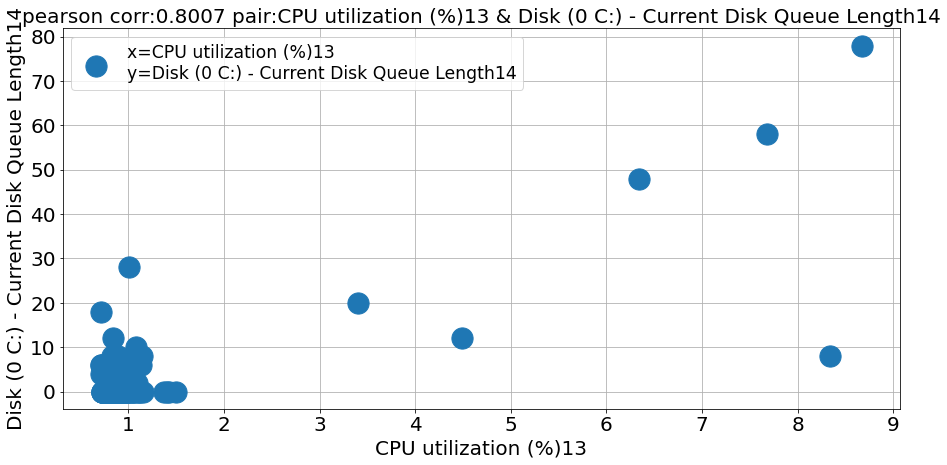

save as CPU utilization (%)13 & Disk (0 C:) - Current Disk Queue Length19_corr_plot.jpg


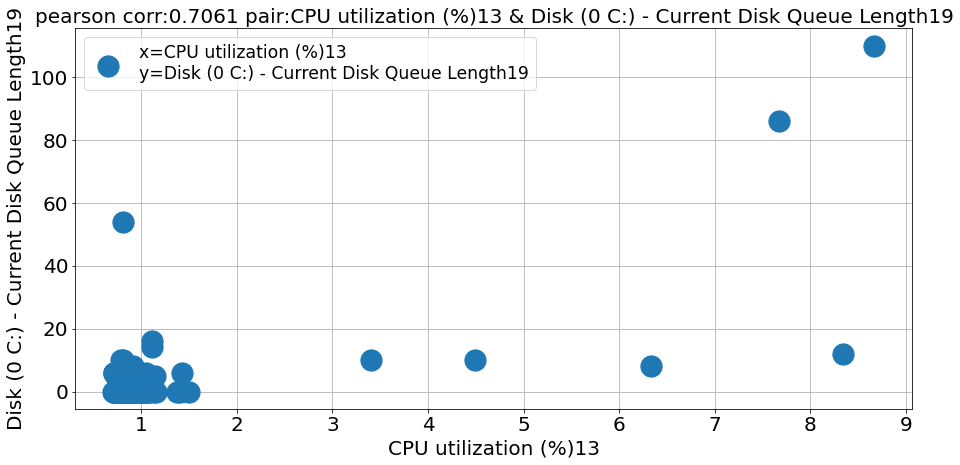

save as Disk (0 C:) - Current Disk Queue Length14 & Label16_corr_plot.jpg


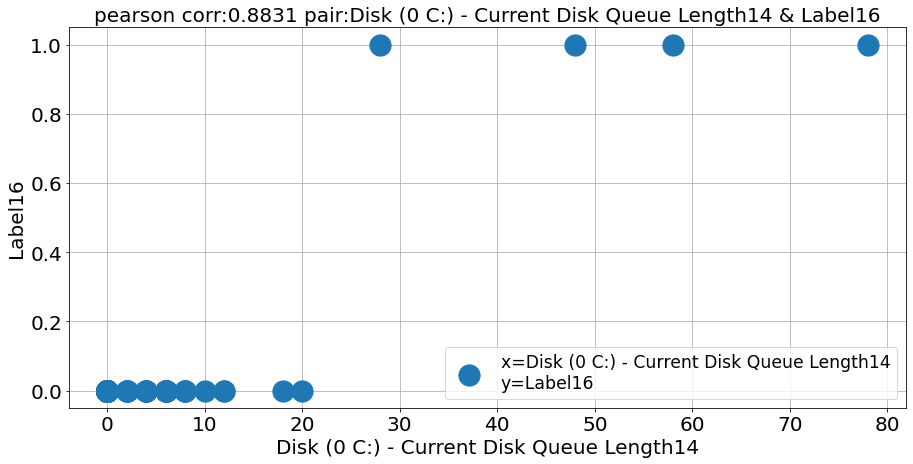

save as Disk (0 C:) - Current Disk Queue Length14 & Disk (0 C:) - Current Disk Queue Length19_corr_plot.jpg


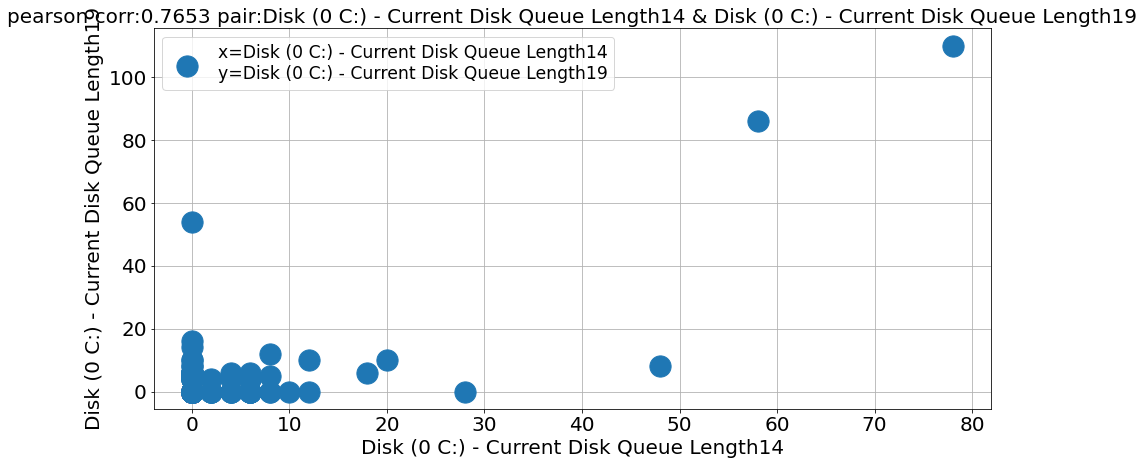

save as Disk (0 C:) - Current Disk Queue Length19 & Label21_corr_plot.jpg


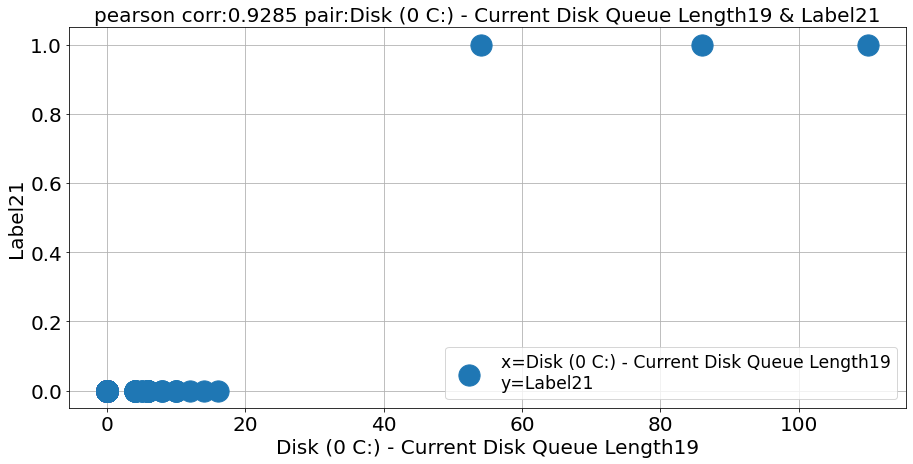

save as Disk (0 C:) - Current Disk Queue Length19 & Disk (0 C:) - Current Disk Queue Length24_corr_plot.jpg


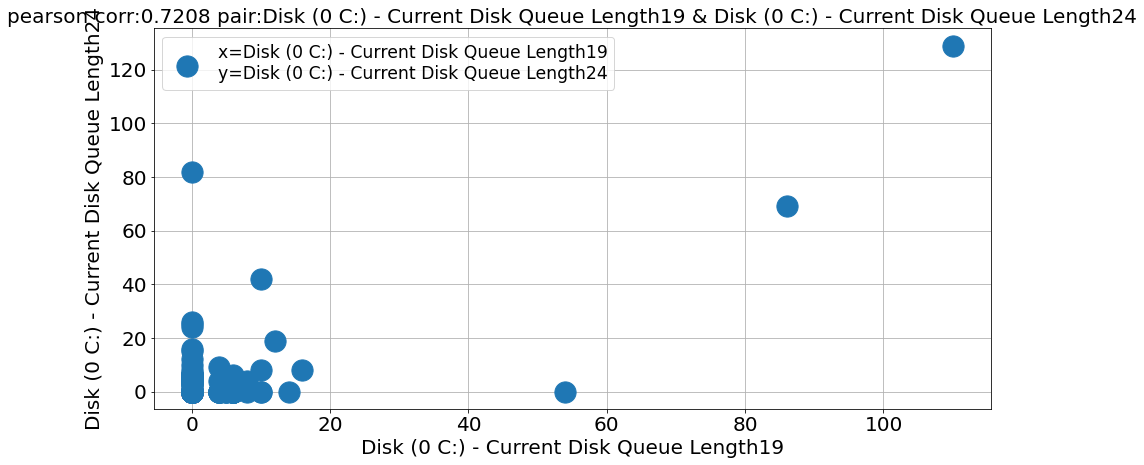

save as Disk (0 C:) - Current Disk Queue Length24 & Label26_corr_plot.jpg


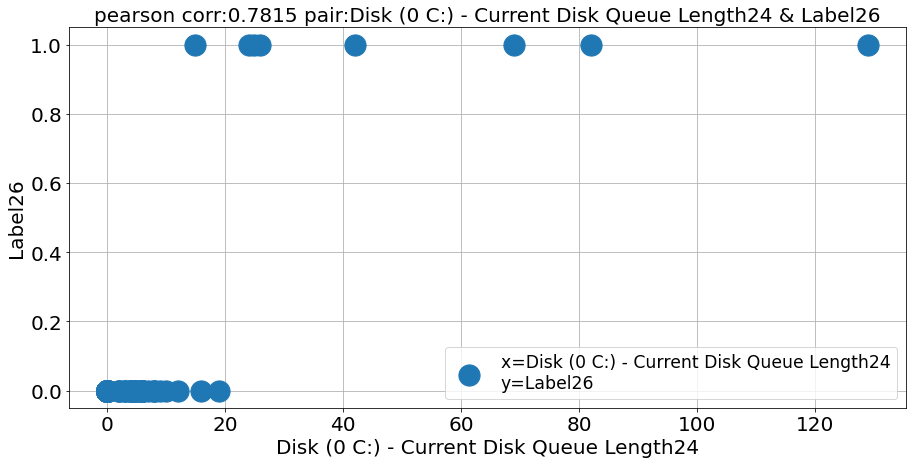

0 Memory used  (%)
1 CPU utilization (%)
2 Disk (0 C:) - Current Disk Queue Length
3 Disk (1 D:) - Current Disk Queue Length
4 Label
5 Memory used  (%)2
6 CPU utilization (%)3
7 Disk (0 C:) - Current Disk Queue Length4
8 Disk (1 D:) - Current Disk Queue Length5
9 Label6
10 Memory used  (%)7
11 CPU utilization (%)8
12 Disk (0 C:) - Current Disk Queue Length9
13 Disk (1 D:) - Current Disk Queue Length10
14 Label11
15 Memory used  (%)12
16 CPU utilization (%)13
17 Disk (0 C:) - Current Disk Queue Length14
18 Disk (1 D:) - Current Disk Queue Length15
19 Label16
20 Memory used  (%)17
21 CPU utilization (%)18
22 Disk (0 C:) - Current Disk Queue Length19
23 Disk (1 D:) - Current Disk Queue Length20
24 Label21
25 Memory used  (%)22
26 CPU utilization (%)23
27 Disk (0 C:) - Current Disk Queue Length24
28 Disk (1 D:) - Current Disk Queue Length25
29 Label26


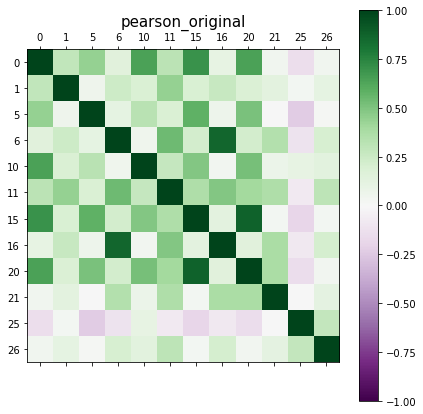

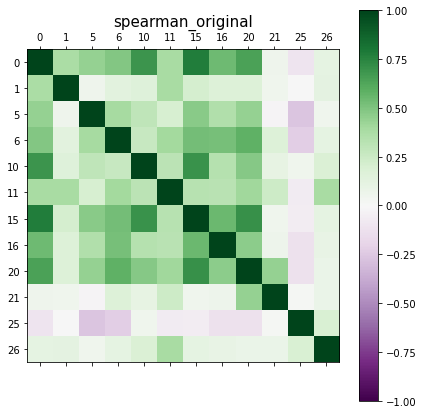

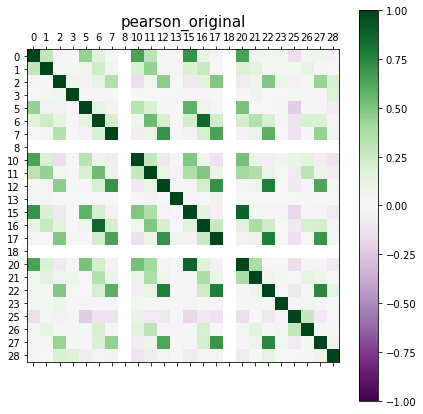

In [87]:
def plot_corr_pair(df,corr_df,index_col,method):

    x_col = index_col.split(" & ")[0]
    y_col = index_col.split(" & ")[1]
    
    #plt.fill_between([0,100],20,[3,3],linewidth=20,facecolor='red', alpha=0.10,zorder=10)
    plt.scatter(df[x_col].values,
                df[y_col].values,
                s=450,
                label="x={}\ny={}".format(x_col,y_col),
                zorder=20)
          
    plt.xlabel(x_col,fontsize=20)
    plt.ylabel(y_col,fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.xticks(fontsize=20,rotation=0)
    plt.yticks(fontsize=20)
    plt.title("{} corr:{} pair:{}".format(method,
                                          corr_df.loc[index_col,"r value"],
                                          index_col),
              fontsize=20)
    plt.grid()
    if "Disk" in x_col:
        x_col = x_col.split(":")[0]
    if "Disk" in y_col:
        y_col = y_col.split(":")[0]
    plt.savefig(os.path.join(r"E:\Server_mantain\Zabbix_Online_detection\Dataset\OPTIdata\pre_process_withlabel\correlation_plot",
                            "{} & {}_corr_plot.jpg".format(x_col,y_col)))
    print("save as {}_corr_plot.jpg".format(index_col))
    plt.show()
    
#1v~6v corr
df = read_data(os.path.join(root_path,
                      "OPTIdata",
                      "pre_process_withlabel",
                      "1vto6v_server_180dayswithanomaly_resampleHOUR_quene_sum_concat.csv"),
                      o_dtname="dt",
                        c_dtname='Datetime')

import researchpy as rp

corr_type,corr_matrix,corr_ps = rp.corr_case(df)
pearson_res = rp.corr_pair(df.loc["2021/9/11 09:34":]).astype("float")
spear_res = rp.corr_pair(df.loc["2021/9/11 09:34":],method="spearman").astype("float")
pearson_res = pearson_res.dropna(how='any')
spear_res = spear_res.dropna(how='any')
pearson_res.to_csv("1vto6v_pearson_correlation0911.csv")
spear_res.to_csv("1vto6v_spear_correlation0911.csv")

r_threshold = 0.7
p_threshold = 0.15
high_cor_ind = pearson_res[pearson_res["r value"].abs() >= r_threshold].index.values

for ind in high_cor_ind:
    plot_corr_pair(df.loc["2021/9/11 09:34":],pearson_res,ind,"pearson")


for i ,col in enumerate(df.columns):
    print(i ,col)
    
show_corr(df,[0,1,5,6,10,11,15,16,20,21,25,26],method="pearson")
show_corr(df,[0,1,5,6,10,11,15,16,20,21,25,26],method="spearman")

show_corr(df,[0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18,20,21,22,23,25,26,27,28],method="pearson")


### Tsfresh Analysis

### PCA Analysis

### PyOD Analysis